# welch method

Making sure we're implementing welch's method correctly.

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal

from sklearn import linear_model

plt.figure(figsize=(16,10))
%matplotlib inline

In [4]:
class Subject:

    def __init__(self, importpath, importpath_evt, group='', age=0, sex=0):
        datafile = sp.io.loadmat(importpath)
        self.name   = str(np.squeeze(datafile['name']))
        self.group  = group
        self.age    = age
        self.sex    = sex
        self.srate  = int(np.squeeze(datafile['srate']))
        self.data   = np.squeeze(datafile['data'])
        self.nbchan = len(self.data)
        self.events = {}
        self.events['df'] = pd.read_csv(importpath_evt, sep='\t')
        self._construct_event_hierarchy()


    def _construct_event_hierarchy(self):
        self.events['df'].Type = self.events['df'].Type.map(
            lambda x: x[0:2][::-1] if len(x) == 3 else x
        )
        self.events['types'] = set(map(lambda x: x[0], self.events['df'].Type))
        for event_type in self.events['types']:
            if event_type == 'C':
                self._organize_events_into_df('eyesc', event_type)
            elif event_type == 'O':
                self._organize_events_into_df('eyeso', event_type)
            elif event_type == '0':
                self._organize_events_into_df('trials_eyesc', event_type)
            elif event_type == '1':
                self._organize_events_into_df('trials_eyeso', event_type)


    def _organize_events_into_df(self, event_label, event_type):
        self.events[event_label] = []
        idx = list(map(lambda x: True if x[0] == event_type\
                                      else False, self.events['df'].Type))
        events = self.events['df'][idx]
        for i in range(events.shape[0]):
            if events.iloc[i].Type == event_type + '1':
                self.events[event_label].append(
                    [events.iloc[i].Latency, events.iloc[i+1].Latency]
                )


    def _update_event_hierarchy(self):
        """
        Checks to make sure that clean segments fall inside of trials.
        For example, run this after running modify_trial_length().
        """
        self.events['df'] = rm_intertrial_segs(self.events['df'])
        self._construct_event_hierarchy()


    def modify_trial_length(self, new_trial_length):
        """
        Reduces or increases trial lengths and modifies clean segment
        markers to reflect new trial lengths.
        """
        df = self.events['df'].copy()
        for i in range(df.shape[0]):
            if df.iloc[i].Type in ['01', '11']:
                for j in range(i+1, df.shape[0]):
                    if df.iloc[j].Type in ['02', '12']:
                        break
                df.at[j, 'Latency'] = df.iloc[i].Latency + new_trial_length
        self.events['df'] = df.copy()
        self._update_event_hierarchy()


    def get_windows(self, chan, seg_type, nperwindow=512*2, noverlap=512):
        """ Grabs windows of data of size nperwindow with overlap noverlap.
        TODO: Update. This is technically not a correct implementation of Welch's method,
        but it works if noverlap is 50 percent of the window length.
        Arguments
            chan:       Integer, channel number from which to extract windows.
            seg_type:   String, specifies what segments to use. Possible options are
                        'C' or 'O'.
            nperwindow: Time-points to use per window. Default value, provided sampling rate
                        is 512 Hz, is 2 seconds.
            noverlap:   Overlap of windows. Default is 50%.
        """
        wins = []
        for event in self.events[seg_type]:
            event_length = event[1] - event[0]
            if event_length >= nperwindow:
                current_idx = 0
                while current_idx + nperwindow <= event_length:
                    wins.append(self.data[chan][current_idx : current_idx+nperwindow])
                    current_idx += noverlap
        return wins


    def welch(self, windows, srate):
        """
        Takes a list of data segments (each size 1xN), computes each segment's PSD,
        and averages them to get a final PSD.
        """
        # psds = [sp.signal.periodogram(window, srate, window='hamming')[1] for window in windows]
        psds = [sp.signal.welch(window, srate, nperseg=len(window), window='hamming')[1] for window in windows]
        return np.mean(psds, axis=0)


    def remove_freq_buffer(self, data, lofreq, hifreq):
        """
        Removes a frequency buffer from a PSD or frequency vector.
        """
        data = np.delete(data, range(lofreq*2, hifreq*2))
        return data.reshape(len(data), 1)


    def compute_ch_psds(self, match_OA_protocol=True, manual_win_extraction=False,
                                            nwins_upperlimit=-1, rand_wins=False):
        """ Returns subj data structure with calculated PSDs and subject information.
        Arguments:
            import_path:          String, path to .mat files
            import_path_csv:      String, path to .csv containing subject class, sex, and
                                  age information.
            cut_recording_length: Boolean, specifies whether to cut recordings down to 7
                                  minutes.
            nwins_upperlimit:     Scalar, specifies the upperlimit of windows to extract
                                  from a given subject. A value of -1 means no upper limit.
        """

        self.psds = {}
        self.f = np.linspace(0, 256, 513)
        self.f = self.f.reshape(len(self.f), 1)
        self.f_rm_alpha = self.remove_freq_buffer(self.f, 7, 14)

        # Cut trials down to match older adults; 30 seconds
        if match_OA_protocol and self.name[0:3] == '112':
            self.modify_trial_length(512 * 30)

        for ch in range(self.nbchan):
            self.psds[ch] = {}

            if manual_win_extraction:
                eyesc_windows = self.get_windows(ch, 'eyesc')
                eyeso_windows = self.get_windows(ch, 'eyeso')

                # Remove windows if there's an upper-limit and windows
                # are selected randomly.
                if nwins_upperlimit != -1 and rand_wins:
                    while len(eyesc_windows) > nwins_upperlimit:
                        if rand_wins:
                            random.shuffle(eyesc_wins)
                            eyesc_wins.pop()
                        else:
                            eyesc_windows.pop()
                    while len(eyeso_windows) > nwins_upperlimit:
                        if rand_wins:
                            random.shuffle(eyeso_windows)
                            eyeso_windows.pop(random.randrange(eyeso_windows))
                        else:
                            eyeso_windows.pop()

                self.psds[ch]['eyesc'] = self.welch(eyesc_windows, 512)
                self.psds[ch]['eyeso'] = self.welch(eyeso_windows, 512)
            else:
                eyesc_segs = [self.data[ch][event[0] : event[1]] for event in self.events['eyesc']]
                eyeso_segs = [self.data[ch][event[0] : event[1]] for event in self.events['eyeso']]
                eyesc_psds = []
                eyeso_psds = []
                for seg in eyesc_segs:
                    if len(seg) >= 1024:
                        eyesc_psds.append(sp.signal.welch(seg, 512, nperseg=1024, noverlap=512, window='hamming')[1])
                for seg in eyeso_segs:
                    if len(seg) >= 1024:
                        eyeso_psds.append(sp.signal.welch(seg, 512, nperseg=1024, noverlap=512, window='hamming')[1])
                self.psds[ch]['eyesc'] = np.mean(eyesc_psds, axis=0)
                self.psds[ch]['eyeso'] = np.mean(eyeso_psds, axis=0)

        if manual_win_extraction:
            self.nwins_eyesc = len(eyesc_windows)
            self.nwins_eyeso = len(eyeso_windows)
        else:
            self.nwins_eyesc = 0
            self.nwins_eyeso = 0
            for event in self.events['eyesc']:
                event_length = event[1] - event[0]
                if event_length >= 1024:
                    self.nwins_eyesc += (event_length//512) - 1
            for event in self.events['eyeso']:
                event_length = event[1] - event[0]
                if event_length >= 1024:
                    self.nwins_eyeso += (event_length//512) - 1
        self.data = [] # Clear it from memory since it's no longer needed.


    def linreg_slope(self, f, psd, lofreq, hifreq):
        """
        Fits line to the PSD, using simple linear regression.
        Returns slope and fit line.
        """
        model = linear_model.LinearRegression()
        model.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
        fit_line = model.predict(f)
        return model.coef_[0] * (10**2), fit_line


    def ransac_slope(self, f, psd, lofreq, hifreq):
        """
        Robustly fits line to the PSD, using the RANSAC algorithm.
        Returns slope and fit line.
        """
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
        fit_line = model_ransac.predict(f)
        return model_ransac.estimator_.coef_[0] * (10**2), fit_line


    def fit_slopes(self, regr_func_str='ransac',
                    buffer_lofreq=7, buffer_hifreq=14,
                    fitting_lofreq=2, fitting_hifreq=24):
        if regr_func_str == 'ransac':
            regr_func = self.ransac_slope
        elif regr_func_str == 'linreg':
            regr_func = self.linreg_slope
        for ch in range(self.nbchan):
            self.psds[ch]['eyesc_rm_alpha'] = self.remove_freq_buffer(self.psds[ch]['eyesc'], buffer_lofreq, buffer_hifreq)
            self.psds[ch]['eyeso_rm_alpha'] = self.remove_freq_buffer(self.psds[ch]['eyeso'], buffer_lofreq, buffer_hifreq)
            eyesc_slope, eyesc_fitline = regr_func(self.f_rm_alpha, self.psds[ch]['eyesc_rm_alpha'], fitting_lofreq, fitting_hifreq)
            eyeso_slope, eyeso_fitline = regr_func(self.f_rm_alpha, self.psds[ch]['eyeso_rm_alpha'], fitting_lofreq, fitting_hifreq)
            self.psds[ch]['eyesc_slope'], self.psds[ch]['eyesc_fitline'] = eyesc_slope, eyesc_fitline
            self.psds[ch]['eyeso_slope'], self.psds[ch]['eyeso_fitline'] = eyeso_slope, eyeso_fitline


"""
Set of functions for cleaning up event dataframes.
"""

def get_previous_trial(code_latency, trials):
    """
    Returns closest previous trial to the provided latency from the dataframe
    trials.
    """
    prev_trial = trials[trials.Latency < code_latency].tail(1)
    return prev_trial.set_index(np.arange(0, prev_trial.shape[0], 1))


def get_next_trial(code_latency, trials):
    """
    Returns the closest next trial to the provided latency from the dataframe
    trials.
    """
    next_trial = trials[trials.Latency > code_latency].head(1)
    return next_trial.set_index(np.arange(0, next_trial.shape[0], 1))


def in_intertrial(code_latency, trials):
    """
    Returns boolean specifying whether the given latency sits inside of the
    intertrial space defined by the dataframe trials.
    """
    try:
        if get_previous_trial(code_latency, trials).Type.all() in ['12', '02']:
            return True
        else:
            return False
    except:
        return True


def rm_intertrial_segs(df):
    SEGS_START = ['C1', 'O1']
    SEGS_STOP = ['C2', 'O2']
    TRIALS_START = ['11', '01']
    TRIALS_STOP = ['12', '02']

    trials = df[[code in TRIALS_START + TRIALS_STOP for code in df.Type]]

    # CASE 1: Segment sits wholly in intertrial space. Remove the whole thing.
    bad_idx = []
    for i in range(df.shape[0]):
        if df.iloc[i].Type in SEGS_START and (in_intertrial(df.iloc[i].Latency, trials) and
                                              in_intertrial(df.iloc[i+1].Latency, trials)):
            bad_idx.append(i)
            bad_idx.append(i+1)
    df = df.drop(df.index[bad_idx])
    df = df.set_index(np.arange(0, df.shape[0], 1))

    for i in range(df.shape[0]):
        # CASE 2: Segment head sits inside of the intertrial space. Trim the front of the segment.
        if df.iloc[i].Type in SEGS_START and in_intertrial(df.iloc[i].Latency, trials):
            df.at[i, 'Latency'] = get_next_trial(df.iloc[i].Latency, trials).at[0, 'Latency']

        # CASE 3: Segment tail sits inside of the intertrial space. Trim the end of the segment.
        if df.iloc[i].Type in SEGS_STOP and in_intertrial(df.iloc[i].Latency, trials):
            df.at[i, 'Latency'] = get_previous_trial(df.iloc[i].Latency, trials).at[0, 'Latency']
    return df

In [5]:
s = Subject('../../../data/rs/full/source-dmn/MagCleanEvtFiltCAR-mat/1121181181.mat',
            '../../../data/rs/full/evt/clean/1121181181.evt')
# s.compute_ch_psds()
# s.fit_slopes()

(0, 50)

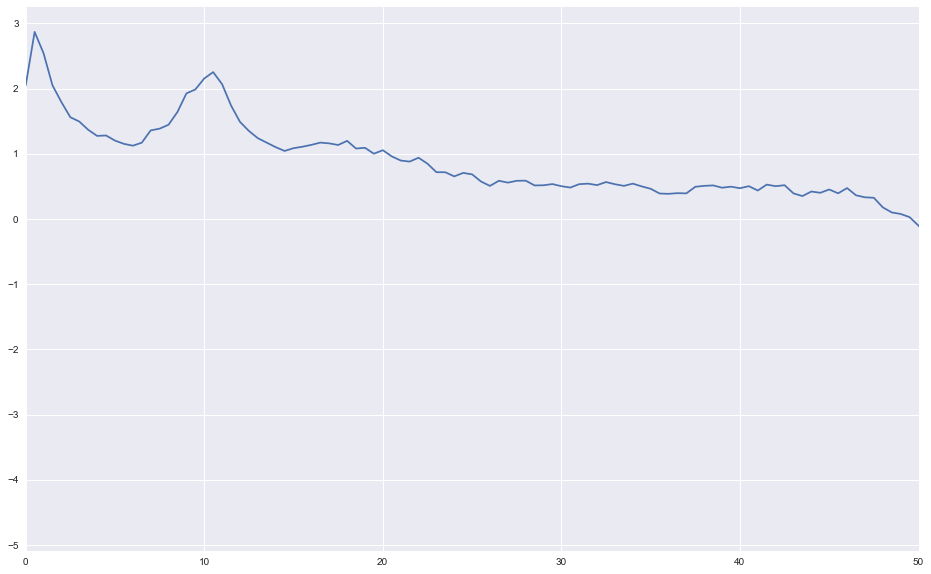

In [27]:
plt.figure(figsize=(16,10))
plt.plot(s.f, np.log10(s.psds[0]['eyesc']))
plt.xlim([0, 50])

In [14]:
segs = []
for event in s.events['eyesc']:
    segs.append(s.data[0][event[0] : event[1]])

In [18]:
len(segs[0])

27033

In [17]:
def man_welch(data, srate, nperseg=1024, noverlap=512):
    wins = []
    current_idx = 0
    while current_idx + nperseg <= len(data):
        wins.append(data[current_idx : current_idx+nperseg])
        current_idx += noverlap
    psds = []
    for w in wins:
        f, psd = sp.signal.periodogram(w, srate, window='hamming')
        psds.append(psd)
    return np.mean(psds, axis=0)

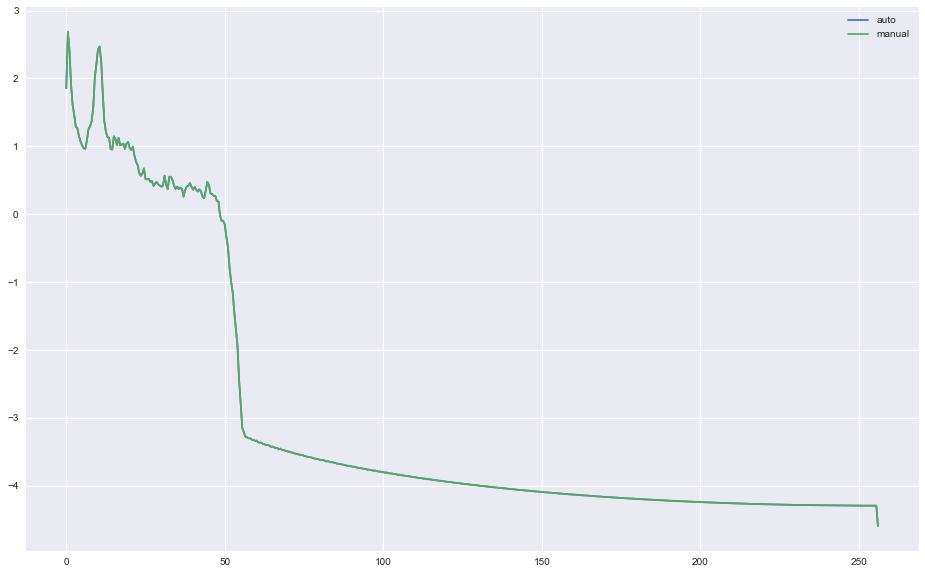

In [25]:
f_w, psd_w = sp.signal.welch(segs[0], 512, nperseg=1024, noverlap=512, window='hamming')
psd_m = man_welch(segs[0], 512, nperseg=1024, noverlap=512)

plt.figure(figsize=(16,10))
plt.plot(f_w, np.log10(psd_w), label='auto')
plt.plot(f_w, np.log10(psd_m), label='manual')
plt.legend()
# plt.xlim([0, 50])

In [27]:
# Method 1: Extract wins, then take PSD. 'true welch'
wins = []
srate = 512
nperseg = 1024
noverlap = 512
for seg in segs:
    if len(seg) >= 1024:
        current_idx = 0
        while current_idx + nperseg <= len(seg):
            wins.append(seg[current_idx : current_idx+nperseg])
            current_idx += noverlap

psds = []
for w in wins:
    f, psd = sp.signal.periodogram(w, srate, window='hamming')
    psds.append(psd)
man_psd = np.mean(psds, axis=0)

In [28]:
# Method 2: PSD of each segment, average those (probably not good)
psds = []
for seg in segs:
    f, psd = sp.signal.welch(seg, srate, nperseg=1024, noverlap=512, window='hamming')
    psds.append(psd)
met2_psd = np.mean(psds, axis=0)

In [36]:
# Method 3: Stitch clean segments together
clean_data = []
for seg in segs:
    clean_data = np.concatenate([clean_data, sp.signal.hamming(len(seg)) * seg])  
f, met3_psd = sp.signal.welch(clean_data, srate, nperseg=1024, noverlap=512)

# Method 4: Stitch, but no hamming
clean_data = []
for seg in segs:
    clean_data = np.concatenate([clean_data, seg])
f, met4_psd = sp.signal.welch(clean_data, srate, nperseg=1024, noverlap=512)

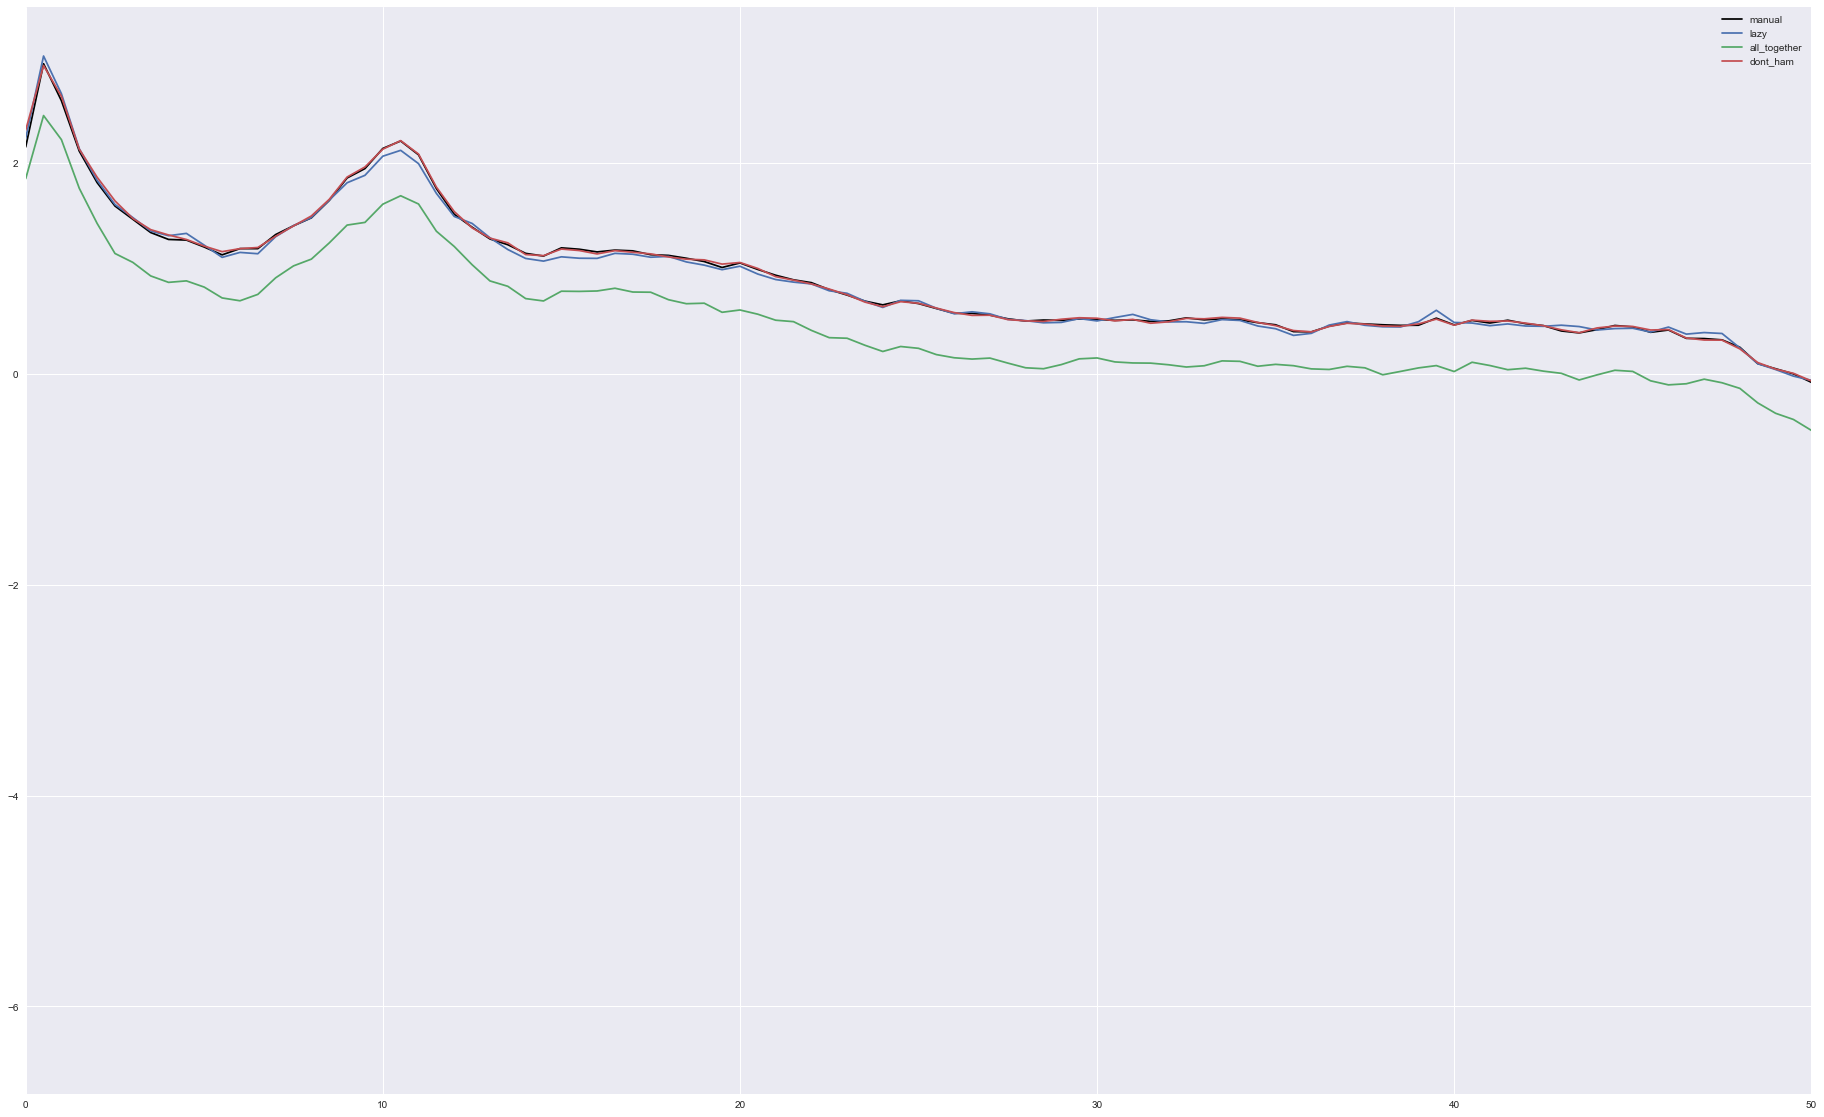

In [41]:
plt.figure(figsize=(16*2,10*2))
plt.plot(f_w, np.log10(man_psd), label='manual', color='black')
plt.plot(f_w, np.log10(met2_psd), label='lazy')
plt.plot(f_w, np.log10(met3_psd), label='all_together')
plt.plot(f_w, np.log10(met4_psd), label='dont_ham')
plt.xlim([0, 50])
plt.legend()
plt.show()

In [43]:
s = Subject('../../../data/rs/full/source-dmn/MagCleanEvtFiltCAR-mat/1121181181.mat',
            '../../../data/rs/full/evt/clean/1121181181.evt')

In [49]:
segs = []
for event in s.events['eyesc']:
    segs.append(s.data[0][event[0] : event[1]])

wins = []
for seg in segs:
    if len(seg) >= 1024:
        current_idx = 0
        while current_idx + 1024 <= len(seg):
            wins.append(seg[current_idx : current_idx+nperseg])
            current_idx += noverlap

psds = []
for w in wins:
    f, psd = sp.signal.periodogram(w, 512, window='hamming')
    psds.append(psd)

avg_psd = np.mean(psds, axis=0)

In [54]:
np.mean(avg_psd)

5.9157572

(0, 45)

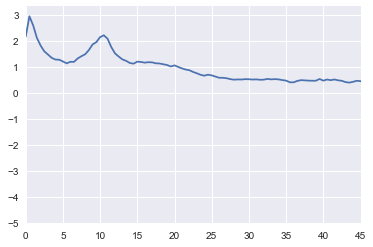

In [53]:
# plt.figure(figsize=(16*2,10*2))
plt.plot(f, np.log10(avg_psd))
plt.xlim([0, 45])

In [51]:
# segs = []
# for event in s.events['eyesc']:
#     segs.append(s.data[0][event[0] : event[1]])

wins = []
for event in s.events['eyesc']:
    if event[1]-event[0] >= 1024:
        current_idx = event[0]
        
        
    
for seg in segs:
    if len(seg) >= 1024:
        current_idx = 0
        while current_idx + 1024 <= len(seg):
            wins.append(seg[current_idx : current_idx+nperseg])
            current_idx += noverlap

psds = []
for w in wins:
    f, psd = sp.signal.periodogram(w, 512, window='hamming')
    psds.append(psd)

avg_psd = np.mean(psds, axis=0)